"""autoencoder_simulation2.ipynb
# Author:
Richard Bruce Baxter - Copyright (c) 2020-2024 Baxter AI (baxterai.com)

(test harness: The Tensorflow Authors)
# License:
Apache License, Version 2.0
# Installation:
Google Colab
# Usage:
Google Colab
# Description:
autoencoder_simulation2.ipynb - learning algorithm is based on AEANNtf (Autoencoder generated artificial neural network)
"""

## Import TensorFlow and other libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Dense, Input, Add

## Load the dataset
To start, you will train the basic autoencoder using the Fashon MNIST dataset. Each image in this dataset is 28x28 pixels.

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

4422102/4422102 [==============================] - 1s 0us/step
(60000, 28, 28)
(10000, 28, 28)


## Multilayer autoencoder (greedy training)

In [3]:
useActivationFunctionF = True   #optional
autoencoderPrediction = "inputLayer"    #required (AEORtf uses no supervised output, so must predict inputLayer)

numberOfLayers = 10
numberOfEpochs = 10
batchSize = 32

imageSize = (28, 28)
multipleLayers = True
supportSkipLayers = True    #full connectivity to all previous layers
if(supportSkipLayers):
    residualConnections = False
else:
    residualConnections = True  #simple addition of previous layer output
simulateCorticalCircuit = True  #mandatory (single layer training)
firstLayerMultiplier = 2  #limited by tensorflow GPU memory

latent_dim = 64

class EncoderLX(Model):
  def __init__(self, latent_dim, io_dim, layerIndex):
    super(EncoderLX, self).__init__()
    self.layerIndex = layerIndex
    self.io_dim = io_dim
    self.latent_dim = latent_dim
    if(supportSkipLayers):
        self.encoders = []
        for i in range(layerIndex+1):
            encoder = tf.keras.Sequential([layers.Flatten(),
                                            layers.Dense(latent_dim, activation=None),])
            self.encoders.append(encoder)
    else:
        self.encoder = tf.keras.Sequential([layers.Flatten(),
                                            layers.Dense(latent_dim, activation=None),])
    if(useActivationFunctionF):
        self.encoderact = tf.keras.layers.Activation('relu')

  def call(self, inputs):
    x, inputLayer, AprevLayerAll = inputs
    if(self.layerIndex > 0):
        AprevLayerAll = tf.transpose(AprevLayerAll, perm=[2, 0, 1])
    if(supportSkipLayers):
        for i in range(self.layerIndex+1):
            if(i > 0):
                Zpartial = self.encoders[i](AprevLayerAll[i-1]) #i-1: AprevLayerAll is defined without inputLayer
                encoded = tf.keras.layers.Add()([encoded, Zpartial])    #encoded = encoded + Zpartial
            else:
                Zpartial = self.encoders[i](inputLayer)
                encoded = Zpartial
    else:
        encoded = self.encoder(x)
        if(residualConnections):
            encoded = tf.keras.layers.Average()([encoded, AprevLayerAll])
    if(useActivationFunctionF):
        encoded = self.encoderact(encoded)
    return encoded

class DecoderLX(Model):
  def __init__(self, latent_dim, io_dim, layerIndex):
    super(DecoderLX, self).__init__()
    self.layerIndex = layerIndex
    self.io_dim = io_dim
    self.latent_dim = latent_dim
    if(supportSkipLayers):
        self.decoders = []
        for i in range(layerIndex+1):
            decoder = tf.keras.Sequential([layers.Dense(io_dim[0]*io_dim[1], activation=None),
                                        layers.Reshape((io_dim[0], io_dim[1])),])
            self.decoders.append(decoder)
    else:
        self.decoder = tf.keras.Sequential([layers.Dense(io_dim[0]*io_dim[1], activation=None),
                                        layers.Reshape((io_dim[0], io_dim[1])),])
    self.decoderact = tf.keras.layers.Activation('sigmoid')

  def call(self, inputs):
    x, AprevLayerAll = inputs
    AprevLayerAll = tf.transpose(AprevLayerAll, perm=[2, 0, 1])
    if(supportSkipLayers):
        for i in range(self.layerIndex+1):
            Zpartial = self.decoders[i](AprevLayerAll[i]) #AprevLayerAll is defined without inputLayer
            if(i > 0):
                decoded = tf.keras.layers.Add()([decoded, Zpartial])    #decoded = decoded + Zpartial
            else:
                decoded = Zpartial
    else:
        decoded = self.decoder(x)
        #if(residualConnections):
        #    decoded = tf.keras.layers.Average()([decoded, AprevLayerAll])
    decoded = self.decoderact(decoded)
    return decoded

class AutoencoderLX(Model):
  def __init__(self, latent_dim, io_dim, layerIndex):
    super(AutoencoderLX, self).__init__()
    self.layerIndex = layerIndex
    self.latent_dim = latent_dim
    self.encoder = EncoderLX(latent_dim, io_dim, layerIndex)
    self.decoder = DecoderLX(latent_dim, io_dim, layerIndex)

  def call(self, inputs):
    x, inputLayer, AprevLayerAll = inputs
    encoded = self.encoder(inputs)
    if(self.layerIndex > 0):
        AprevLayerAll = tf.concat((AprevLayerAll, tf.expand_dims(encoded, axis=-1)), axis=-1)
    else:
        AprevLayerAll = tf.expand_dims(encoded, axis=-1)
    hidden = [encoded, AprevLayerAll]
    decoded = self.decoder(hidden)
    return decoded



In [4]:
 def printOutput(decoded_imgs):
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i])
        plt.title("original")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i])
        plt.title("reconstructed")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

l =  0
Epoch 1/10
1875/1875 [==============================] - 8s 3ms/step - loss: 0.0238 - val_loss: 0.0132
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0116 - val_loss: 0.0105
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0100 - val_loss: 0.0097
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0095 - val_loss: 0.0093
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0088 - val_loss: 0.0088
Epoch 10/10
313/313 [==============================] - 0s 1ms/step


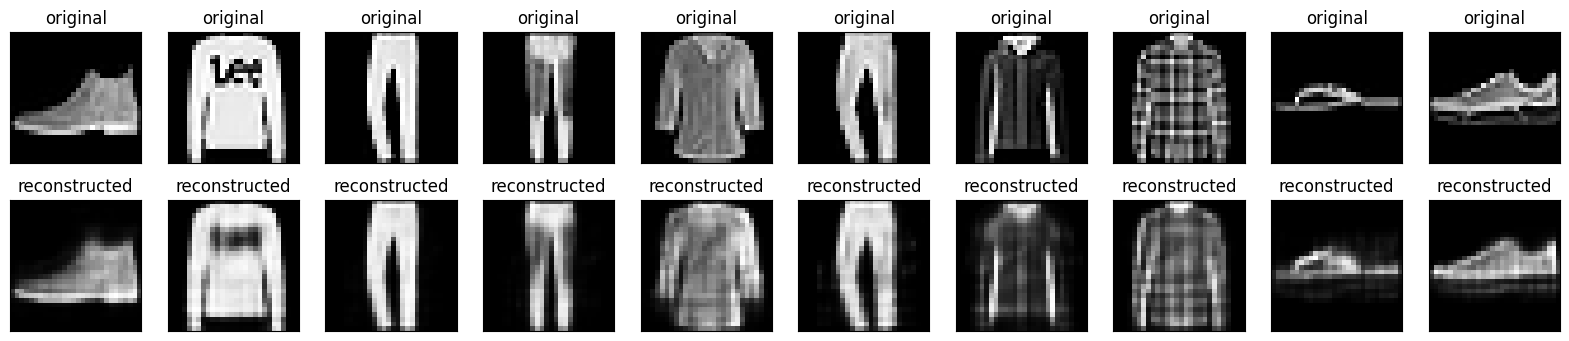

l =  1
Epoch 1/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0148 - val_loss: 0.0091
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0085 - val_loss: 0.0082
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0078 - val_loss: 0.0076
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0072 - val_loss: 0.0071
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0069 - val_loss: 0.0068
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0066 - val_loss: 0.0065
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0064 - val_loss: 0.0064
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0062 - val_loss: 0.0062
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0061 - val_loss: 0.0061
Epoch 10/10
313/313 [==============================] - 0s 1ms/step


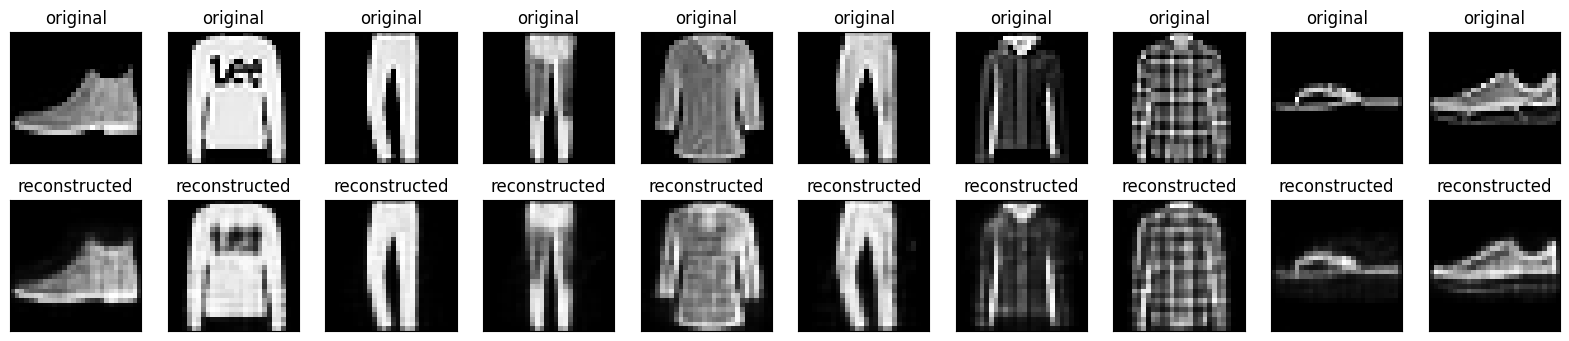

l =  2
Epoch 1/10
1875/1875 [==============================] - 8s 3ms/step - loss: 0.0132 - val_loss: 0.0071
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0064 - val_loss: 0.0061
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0058 - val_loss: 0.0058
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0055 - val_loss: 0.0055
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0052 - val_loss: 0.0052
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0050 - val_loss: 0.0051
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0047 - val_loss: 0.0048
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0047 - val_loss: 0.0048
Epoch 10/10
313/313 [==============================] - 0s 1ms/step


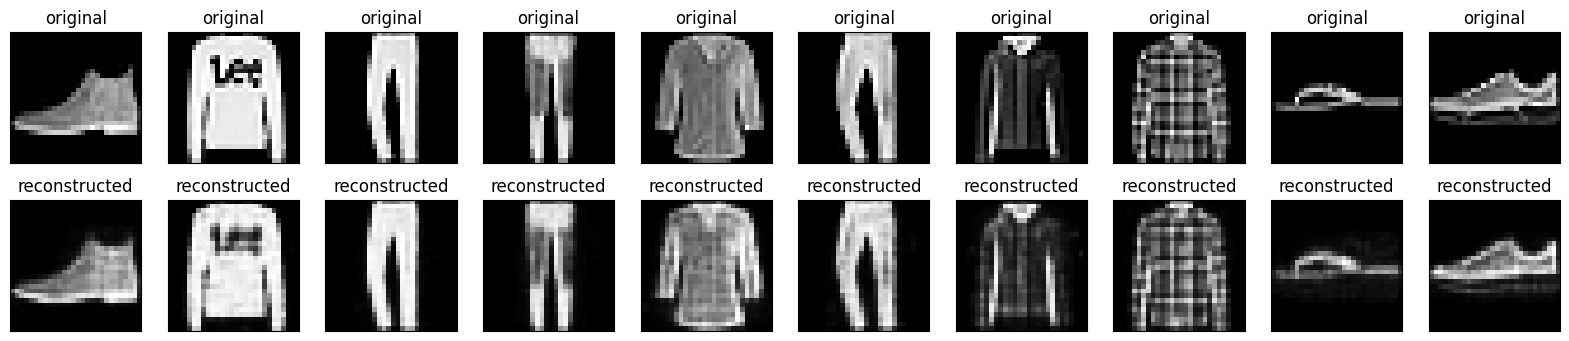

l =  3
Epoch 1/10
1875/1875 [==============================] - 9s 4ms/step - loss: 0.0123 - val_loss: 0.0059
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0052 - val_loss: 0.0049
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0045 - val_loss: 0.0044
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 10/10
313/313 [==============================] - 0s 1ms/step


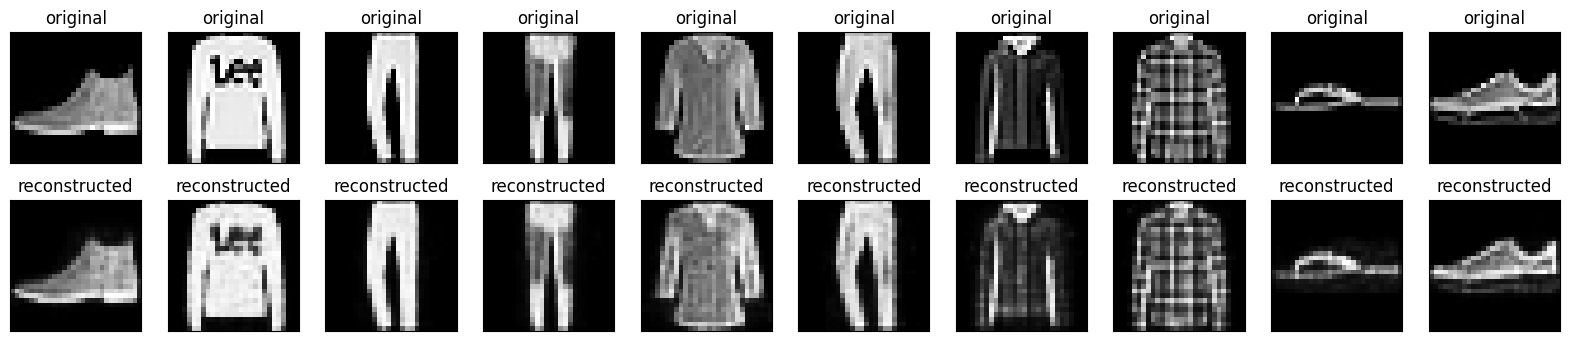

l =  4
Epoch 1/10
1875/1875 [==============================] - 11s 4ms/step - loss: 0.0121 - val_loss: 0.0052
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0045 - val_loss: 0.0042
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 9/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 10/10
313/313 [==============================] - 1s 1ms/step


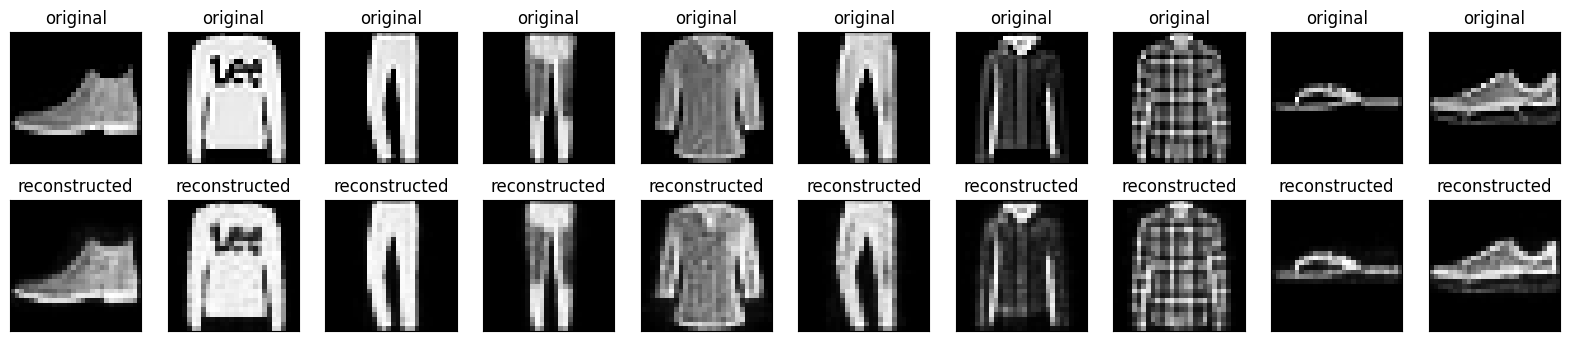

l =  5
Epoch 1/10
1875/1875 [==============================] - 12s 5ms/step - loss: 0.0117 - val_loss: 0.0047
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0040 - val_loss: 0.0037
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 4/10
1875/1875 [==============================] - 8s 5ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 8/10
1875/1875 [==============================] - 8s 5ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 9/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 10/10
313/313 [==============================] - 1s 1ms/step


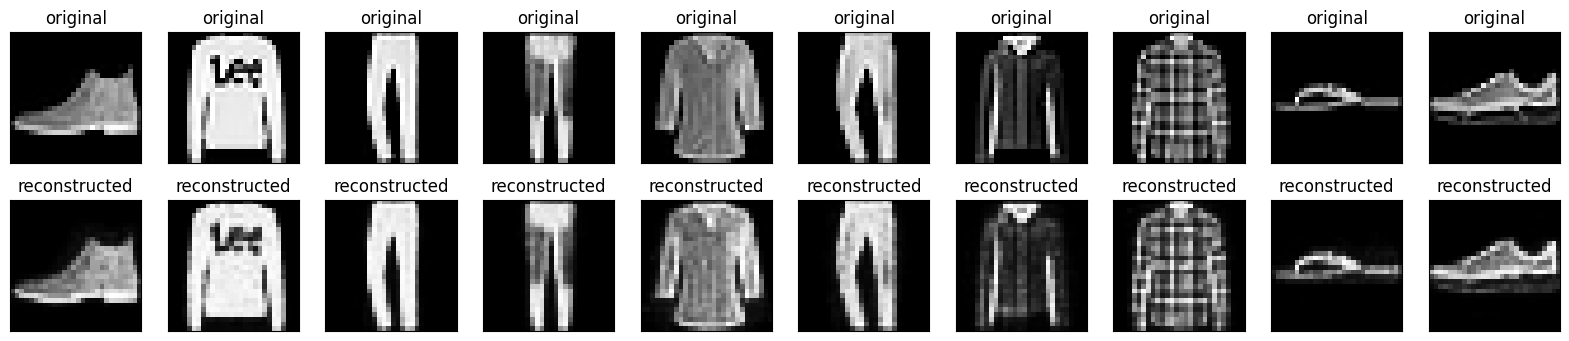

l =  6
Epoch 1/10
1875/1875 [==============================] - 14s 5ms/step - loss: 0.0115 - val_loss: 0.0043
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 8/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 9/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 10/10
313/313 [==============================] - 1s 1ms/step


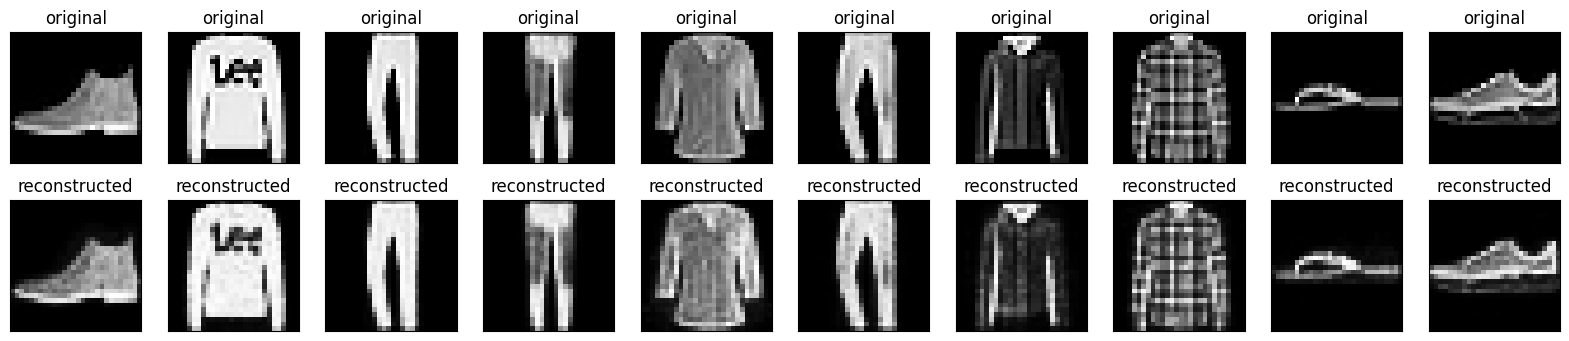

l =  7
Epoch 1/10
1875/1875 [==============================] - 15s 6ms/step - loss: 0.0113 - val_loss: 0.0039
Epoch 2/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 3/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 4/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 5/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 6/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 7/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 8/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 9/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 10/10
313/313 [==============================] - 1s 1ms/step

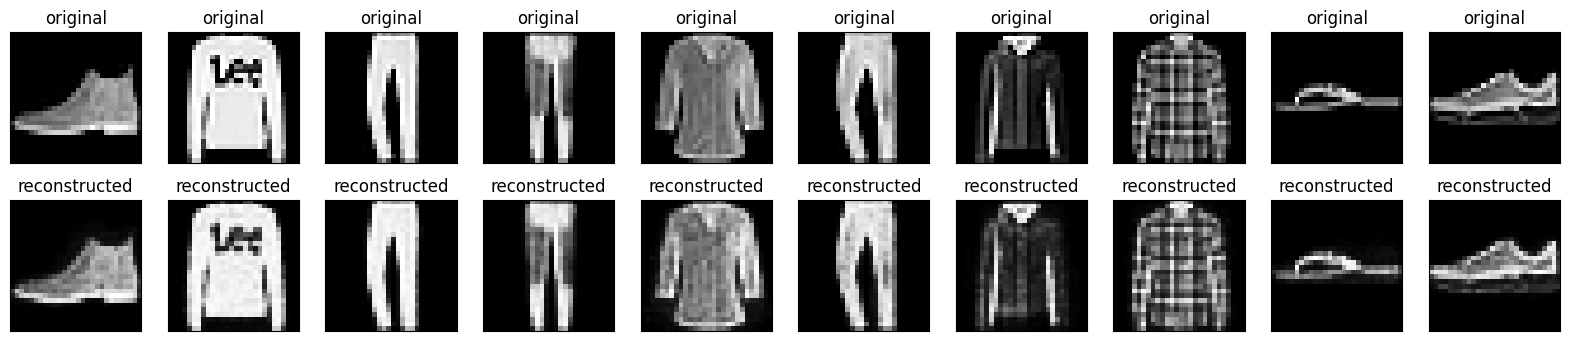

l =  8
Epoch 1/10
1875/1875 [==============================] - 16s 6ms/step - loss: 0.0110 - val_loss: 0.0037
Epoch 2/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 3/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 4/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 5/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 6/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 7/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 8/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 9/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 10/10
313/313 [==============================] - 1s 1ms/step

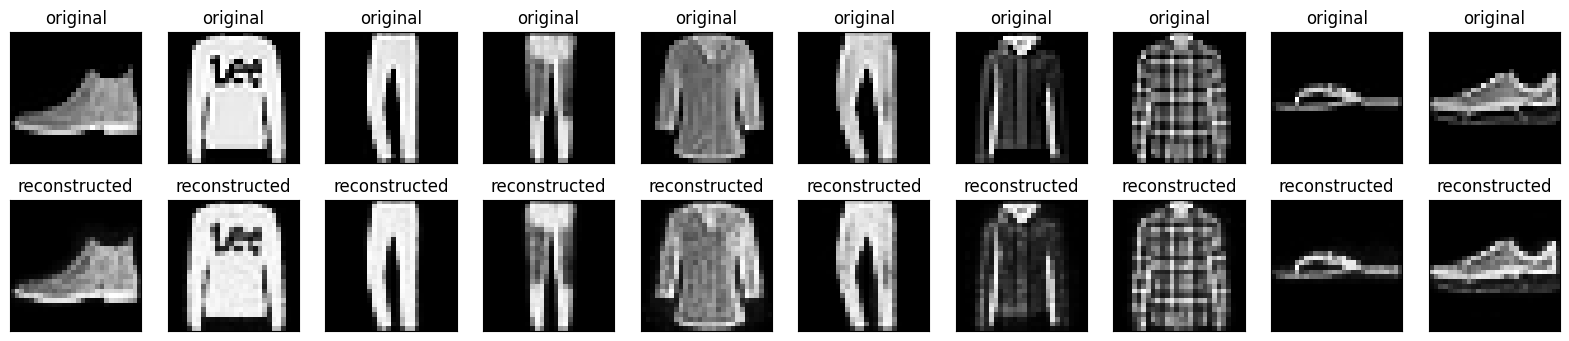

l =  9
Epoch 1/10
1875/1875 [==============================] - 18s 7ms/step - loss: 0.0108 - val_loss: 0.0036
Epoch 2/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 3/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 4/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 5/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 6/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 7/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 8/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 9/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 10/10
313/313 [==============================] - 1s 2ms/step

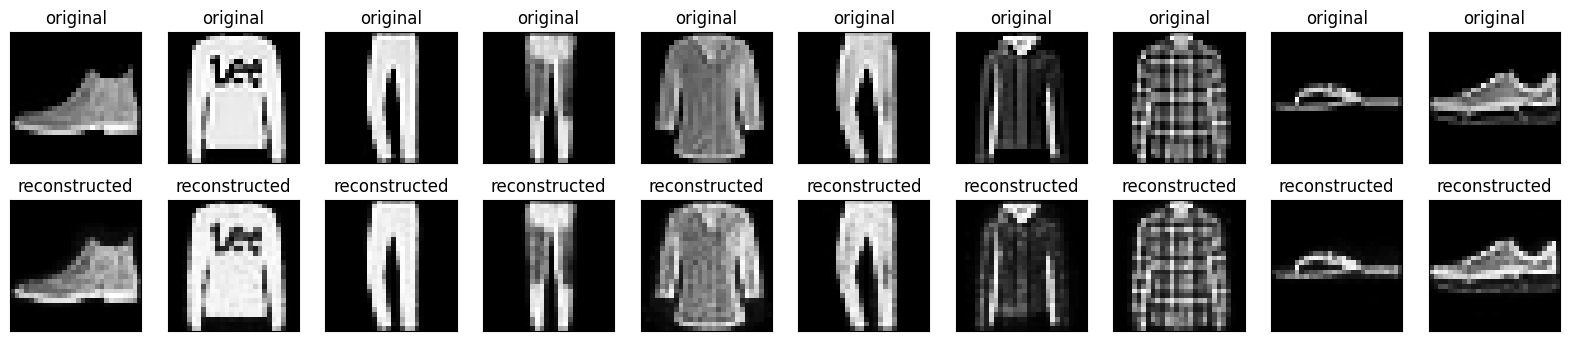

In [5]:
x = x_train
xv = x_test
inputLayer = x_train
inputLayerV = x_test
AprevLayerAll = x   #require to pass tensors to keras model (i=0 is not used; use inputLayer instead)
AprevLayerAllV = xv  #require to pass tensors to keras model (i=0 is not used; use inputLayer instead)
for l in range(numberOfLayers):
    print("l = ", l)
    if(l > 1):
        AprevLayerAll = np.concatenate((AprevLayerAll, np.expand_dims(x, axis=-1)), axis=-1)
        AprevLayerAllV = np.concatenate((AprevLayerAllV, np.expand_dims(xv, axis=-1)), axis=-1)
    elif(l == 1):
        AprevLayerAll = np.expand_dims(x, axis=-1)
        AprevLayerAllV = np.expand_dims(xv, axis=-1)
    autoencoderLX = AutoencoderLX(latent_dim, imageSize, l)
    autoencoderLX.compile(optimizer='adam', loss=losses.MeanSquaredError())
    autoencoderLX.fit([x, inputLayer, AprevLayerAll], x_train, epochs=numberOfEpochs, shuffle=False, batch_size=batchSize, validation_data=([xv, inputLayerV, AprevLayerAllV], x_test))
    out = autoencoderLX.predict([x, inputLayer, AprevLayerAll])
    outv = autoencoderLX.predict([xv, inputLayerV, AprevLayerAllV])
    x = autoencoderLX.encoder.predict([x, inputLayer, AprevLayerAll])
    xv = autoencoderLX.encoder.predict([xv, inputLayerV, AprevLayerAllV])
    decoded_imgs = outv
    printOutput(decoded_imgs)
